In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy, sklearn
import os
import seaborn as sns
import statsmodels.api as sm

In [16]:
#Uzerinde islem yapilan veriler excel dosyasindan okunup x ve y olarak ayrildi
thyroid_df = pd.read_excel("yeni_veriler.xlsx", index_col=0)
X = thyroid_df.drop(labels='Class',axis=1)
y = thyroid_df['Class']
X.shape

(3878, 26)

# Forward Elimination

Forward Elimination yapabilmek için ki p value değeri kullanılarak sırasıyla en küçüğü alınacak şekilde 0.05 ten küçük p value kalmayana kadar özellikler alındı.

In [3]:
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Class   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.856
Method:                 Least Squares   F-statistic:                              888.2
Date:                Mon, 14 Jun 2021   Prob (F-statistic):                        0.00
Time:                        22:14:36   Log-Likelihood:                         -386.90
No. Observations:                3878   AIC:                                      825.8
Df Residuals:                    3852   BIC:                                      988.6
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [4]:
def forwardSelection(x, y, p_value_level=0.05):
    # başlangıç değişkenleri
    initial_features = x.columns.tolist()

    # en iyi değişkenlerin listesi
    best_features = []

    loop_count = 0
    
    # değişken sayısı kadar while döngüsünün çalışması
    while (len(initial_features) > 0):


        loop_count += 1


        # seçilen değişkenler kalan değişkenlerden çıkarılır
        remaining_features = list(set(initial_features) - set(best_features))


        # kalan değişkenler için p değer tablosu
        new_pval = pd.Series(index=remaining_features, dtype='float64')

        # kalan değişkenlerin tek p değeri hesaplanır
        for feature in remaining_features:
            # verilen değişkenler ile model oluşturulur
            model = sm.OLS(y, sm.add_constant(x[best_features + [feature]])).fit()

            # newpval tablosuna değişken ismi ve p değeri eklenir
            new_pval[feature] = model.pvalues[feature]

        # new_pval tablosundaki minimum p değeri alınır
        min_p_value = new_pval.min()

        # eğer p değeri 0.05 altındaysa while döngüsü devam eder
        if(min_p_value < p_value_level):
            best_features.append(new_pval.idxmin())
        
        # eğer P değeri 0.05'in üzerinde ise döngü sona erer
        else:
            break

    return best_features

best_columns= forwardSelection(X,y)

In [5]:
X_selected = pd.DataFrame()
for column in best_columns:
    tmp = pd.DataFrame()
    tmp = X[column]
    X_selected = pd.concat([X_selected, tmp], axis=1)
X_selected

,T3,On Thyroxine,Hypopituitary,Query Hypothyroid,Goitre,Age,T3 Measured,FTI,Lithium,Sick,Thyroid Surgery,Sex,Query on Thyroxine,I131 Treatment,TT4,T4U,Psych,Pregnant,T4U Measured
0,0.803279,0,0,0,0,0.430108,1,0.621622,0,0,0,0.0,0,0,0.692810,0.813725,0,0,1
1,0.639344,0,0,0,0,0.236559,1,0.633703,0,0,0,0.0,0,0,0.542484,0.674424,0,0,0
2,0.647044,0,0,0,0,0.483871,0,0.695946,0,0,0,1.0,0,0,0.588235,0.588235,0,0,1
3,0.377049,0,0,0,0,0.741935,1,0.358108,0,0,0,0.0,0,0,0.274510,0.549020,0,0,1
4,0.647044,0,0,0,0,0.623656,0,0.412162,0,0,0,0.0,0,0,0.346405,0.598039,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,0.311475,0,0,0,0,0.634409,1,0.641892,0,0,0,1.0,0,0,0.542484,0.588235,0,0,1
3874,0.213115,0,0,1,0,0.623656,1,0.587838,0,0,0,1.0,0,0,0.379085,0.421569,0,0,1
3875,0.081967,0,0,0,0,0.634409,1,0.736486,0,0,0,0.0,0,0,0.444444,0.372549,0,0,1
3876,0.245902,0,0,0,0,0.731183,1,0.547297,0,0,0,0.0,0,0,0.444444,0.568627,0,0,1


Forward elimination sonrasi 26 sütundan 19 sütun kaldı.

# Grid Search, CV

Grid Search algoritması ile makine öğrenmesi algoritmalarındaki en iyi parametrel bulundu. Parametreleri elde ederkenki skorlama yöntemimiz accuracy(doğruluk). Overfittingi engellemek için k-fold cross validation uygulandı.K-fold değerimiz=5

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression



names = ["Nearest Neighbors", "SVM",
         "Decision Tree", "Random Forest",
         "Naive Bayes", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    LogisticRegression(),
]



parameters = {'Nearest Neighbors': [{'n_neighbors':[2,5,10,15,20,30],'p':[1,2,3]}], 
              'SVM': [{'C':[0.1,1,5,10,50,100]}],
              'Decision Tree': [{'criterion': ['gini', 'entropy'],'splitter': ['best','random'],'max_depth': [15,30,60]}],
              'Random Forest': [{'n_estimators': [10,50,100,150,200],'criterion': ['gini', 'entropy']}],
              'Naive Bayes': [{}],
              'Logistic Regression': [{'C': [0.5, 1, 1.5], 'max_iter': [100,200,300,400,600,800,1500], 'solver': ['newton-cg','saga']}],}


for name, classifier in zip(names, classifiers):
    print("******",name,"*******")
    grid_search = GridSearchCV(estimator = classifier, #classifier algorithm
                     param_grid = parameters[name], #parameters for classifier
                     scoring = 'accuracy',
                     cv = 5,#cross validation
                     n_jobs = -1)
    gs_result = grid_search.fit(X_selected, y.ravel())
    best_score = gs_result.best_score_
    best_parameters = gs_result.best_params_
    print(best_score)
    print(best_parameters)


****** Nearest Neighbors *******
0.9930379115397405
{'n_neighbors': 2, 'p': 1}
****** SVM *******
0.9847884935151313
{'C': 100}
****** Decision Tree *******
0.9953598270701697
{'criterion': 'gini', 'max_depth': 60, 'splitter': 'best'}
****** Random Forest *******
0.9953594945128035
{'criterion': 'entropy', 'n_estimators': 10}
****** Naive Bayes *******
0.6544642500831392
{}
****** Logistic Regression *******
0.9479135350848023
{'C': 1.5, 'max_iter': 100, 'solver': 'newton-cg'}


# Confusion Matrix ve Model Sonucu Degerlendirme Metrikleri

En iyi sonuçlar, K-Nearest Neighbors, Decision Tree ve RandomForest algoritmalarında elde edildi.

Bu algoritmaların Confusion Matrixleri çıkarılıp, accuracy, precision, recall, f1score, cohens kappa skorları karşılaştırıldı.

### KNN

Accuracy:  0.9930376482723053
Recall:  0.9930376482723053
Precision:  0.9931332655137335
F1 Score :  0.9930373107605288
Cohens Kappa :  0.9860752965446107


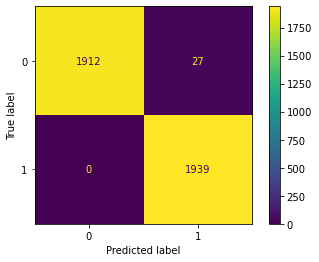

In [20]:
# confusion matrix accuracy precision recall f1 kappa
#turevsiz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, f1_score

classifier = KNeighborsClassifier(n_neighbors=2, p=1)
y_pred = cross_val_predict(classifier, X_selected, y.ravel(), cv=5)


cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("Accuracy: ",accuracy_score(y, y_pred))
print("Recall: ",recall_score(y, y_pred, average = 'macro'))
print("Precision: ",precision_score(y, y_pred, average ='macro'))
print("F1 Score : ",f1_score(y, y_pred, average='macro'))
print("Cohens Kappa : ",cohen_kappa_score(y, y_pred))


### Decision Tree

Accuracy:  0.9948427024239299
Recall:  0.9948427024239299
Precision:  0.9948953547728433
F1 Score :  0.9948425652479332
Cohens Kappa :  0.9896854048478597


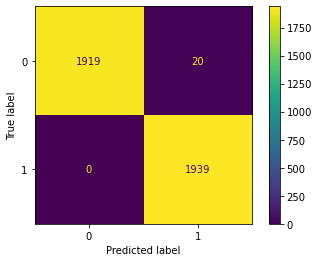

In [11]:
classifier = DecisionTreeClassifier(criterion='gini', max_depth=60, splitter='best')
y_pred = cross_val_predict(classifier, X_selected, y.ravel(), cv=5)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("Accuracy: ",accuracy_score(y, y_pred))
print("Recall: ",recall_score(y, y_pred, average = 'macro'))
print("Precision: ",precision_score(y, y_pred, average ='macro'))
print("F1 Score : ",f1_score(y, y_pred, average='macro'))
print("Cohens Kappa : ",cohen_kappa_score(y, y_pred))

### Random Forest

Accuracy:  0.9938112429087158
Recall:  0.9938112429087158
Precision:  0.9938869077941925
F1 Score :  0.9938110058658196
Cohens Kappa :  0.9876224858174316


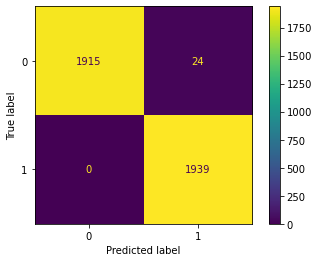

In [12]:
classifier = RandomForestClassifier(criterion='entropy', n_estimators=10)
y_pred = cross_val_predict(classifier, X_selected, y.ravel(), cv=5)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("Accuracy: ",accuracy_score(y, y_pred))
print("Recall: ",recall_score(y, y_pred, average = 'macro'))
print("Precision: ",precision_score(y, y_pred, average ='macro'))
print("F1 Score : ",f1_score(y, y_pred, average='macro'))
print("Cohens Kappa : ",cohen_kappa_score(y, y_pred))